In [12]:
import os
import glob
import random
import tqdm
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import scipy.io as scp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as skio
from torch.utils.data import Dataset, DataLoader 
import pathlib

#file_path = pathlib.Path(__file__).parent.absolute()
file_path = pathlib.Path(os.getcwd())

class MyCNN(nn.Module):
  def __init__(self, num_channels=3, num_out_ch=[8, 16], img_w=100, img_h=100, num_classes=102):
    super(MyCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0], 
                           kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.conv2 = nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1], 
                           kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.fc = nn.Linear(in_features = int(img_w/4)*int(img_h/4)*num_out_ch[1], out_features=num_classes)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = self.fc(x.reshape(x.shape[0], -1))
    return x
  
  def load_model(self, model_name: str):
    # TODO: Carga los pesos de tu red neuronal
    models_path = file_path / 'models' / model_name
    self.load_state_dict(torch.load(models_path, map_location=self.device))

model = MyCNN()
x = torch.randn(32, 3, 100, 100)
y = model(x)
print(y.shape)

torch.Size([32, 102])


In [14]:
NUM_OUT_CH = [8, 16]
IMAGE_W = 200
IMAGE_H = 200
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 0.001

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# model
model = MyCNN(num_channels=3, num_out_ch=NUM_OUT_CH, img_w=IMAGE_W, img_h=IMAGE_H, num_classes=102)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = LR)

# Loss Function
criterion = nn.CrossEntropyLoss()

data_path = 'C:/Users/ruizd/Downloads/jpg/'
label_path = 'G:/Mi unidad/Escuela/8vo Semestre/Sistemas Inteligentes/SI23_Togepis/proyecto_Final/labels/imagelabels.mat'
label_arr = scp.loadmat(label_path)['labels']
label_arr -= 1

df = pd.read_csv("G:/Mi unidad/Escuela/8vo Semestre/Sistemas Inteligentes/SI23_Togepis/proyecto_Final/labels/flower_classification_labels.csv")
CLASSES = df["class"].tolist()

cpu


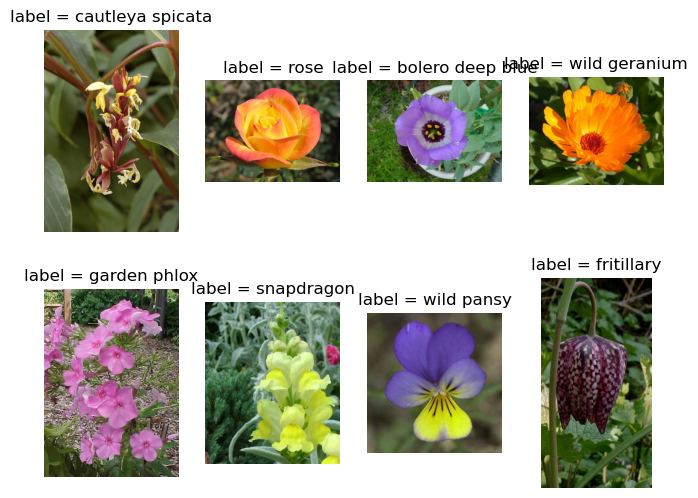

In [16]:
#sorted(os.listdir(data_path))[0]
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8,6))
image_num = random.sample(range(1,8190), 8)
for i in range(2):
  for j in range(4):
    image = skio.imread(os.path.join(data_path, f'image_{image_num[i*4+j]:05}.jpg'))
    ax[i,j].imshow(image)
    ax[i,j].axis('off')
    ax[i,j].set_title(f'label = {CLASSES[label_arr[0,image_num[i*4+j]]]}')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


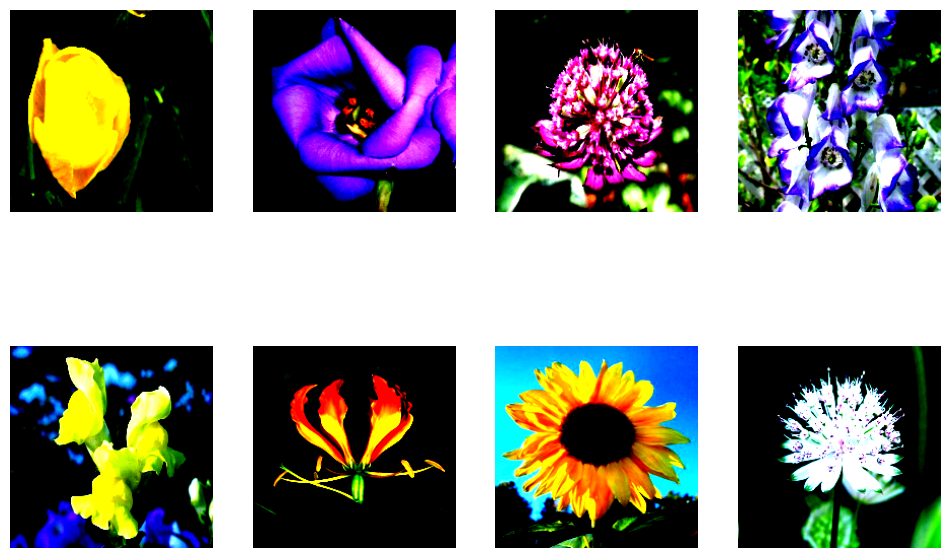

,image_path,image_label
0,C:/Users/ruizd/Downloads/jpg\image_00001.jpg,76
1,C:/Users/ruizd/Downloads/jpg\image_00002.jpg,76
2,C:/Users/ruizd/Downloads/jpg\image_00003.jpg,76
3,C:/Users/ruizd/Downloads/jpg\image_00004.jpg,76
4,C:/Users/ruizd/Downloads/jpg\image_00005.jpg,76
...,...,...
8184,C:/Users/ruizd/Downloads/jpg\image_08185.jpg,61
8185,C:/Users/ruizd/Downloads/jpg\image_08186.jpg,61
8186,C:/Users/ruizd/Downloads/jpg\image_08187.jpg,61
8187,C:/Users/ruizd/Downloads/jpg\image_08188.jpg,61


In [65]:
class MyFlowerDataset(Dataset):
  def __init__(self, metadata, transform=None):
    self.metadata = metadata
    self.transform = transform

  def __len__(self):
    return len(self.metadata)

  def __getitem__(self, idx):
    image_path = self.metadata.iloc[idx, 0]
    image = skio.imread(image_path)
    label = torch.tensor(int(metadata.iloc[idx, 1]))
    label = F.one_hot(label, num_classes=102)
    label = label.float()
    if self.transform:
      image = self.transform(image)

    return (image, label)

flower_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_W, IMAGE_H)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = MyFlowerDataset(metadata, transform = flower_transform)

# Splitting dataset into train and test
train_set, test_set = torch.utils.data.random_split(dataset, [6500, 1689])

# defining the dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

for x,y in train_loader:
  x = x.to(device)
  fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,8))
  for i in range(2):
    for j in range(4):
      ax[i,j].imshow(x[i*4+j].cpu().permute(1,2,0))
      ax[i,j].axis('off')
  break
plt.show()

# data frame: index: 8189; columns: 'path', 'label
labels_list = list(label_arr[0, :])
image_path_list = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
metadata = pd.DataFrame(
    {'image_path': image_path_list,
     'image_label': labels_list}
)
metadata

Training

100%|██████████| 102/102 [01:33<00:00,  1.09batch/s, loss=0.00166]


Epoch 0: train_loss: 0.0027202475889056337, val_loss: 3.357156644282502
Accuracy: 723/1689: 42.81


100%|██████████| 102/102 [01:05<00:00,  1.55batch/s, loss=0.00115]


Epoch 1: train_loss: 0.010305676974502265, val_loss: 3.21865763736237
Accuracy: 732/1689: 43.34


100%|██████████| 102/102 [01:05<00:00,  1.57batch/s, loss=0.000714]


Epoch 2: train_loss: 0.002143049503073973, val_loss: 3.446687833312844
Accuracy: 712/1689: 42.16


100%|██████████| 102/102 [01:05<00:00,  1.56batch/s, loss=0.000667]


Epoch 3: train_loss: 0.005862543395921296, val_loss: 3.2703882129041313
Accuracy: 729/1689: 43.16


100%|██████████| 102/102 [01:05<00:00,  1.55batch/s, loss=0.113]  


Epoch 4: train_loss: 0.027060590538324093, val_loss: 3.754301623524541
Accuracy: 571/1689: 33.81


100%|██████████| 102/102 [01:05<00:00,  1.56batch/s, loss=0.0565]


Epoch 5: train_loss: 0.11954121496163163, val_loss: 3.9659179902909565
Accuracy: 569/1689: 33.69


100%|██████████| 102/102 [01:05<00:00,  1.56batch/s, loss=0.0527]


Epoch 6: train_loss: 0.06784520429723404, val_loss: 3.997733783976011
Accuracy: 599/1689: 35.46


100%|██████████| 102/102 [01:05<00:00,  1.55batch/s, loss=0.0248] 


Epoch 7: train_loss: 0.03798827003030216, val_loss: 3.9791093174701193
Accuracy: 580/1689: 34.34


100%|██████████| 102/102 [01:04<00:00,  1.58batch/s, loss=0.00285]


Epoch 8: train_loss: 0.009752192333632824, val_loss: 3.849359488049649
Accuracy: 616/1689: 36.47


100%|██████████| 102/102 [01:04<00:00,  1.59batch/s, loss=0.00163]


Epoch 9: train_loss: 0.009527725916282804, val_loss: 3.804109865564648
Accuracy: 613/1689: 36.29


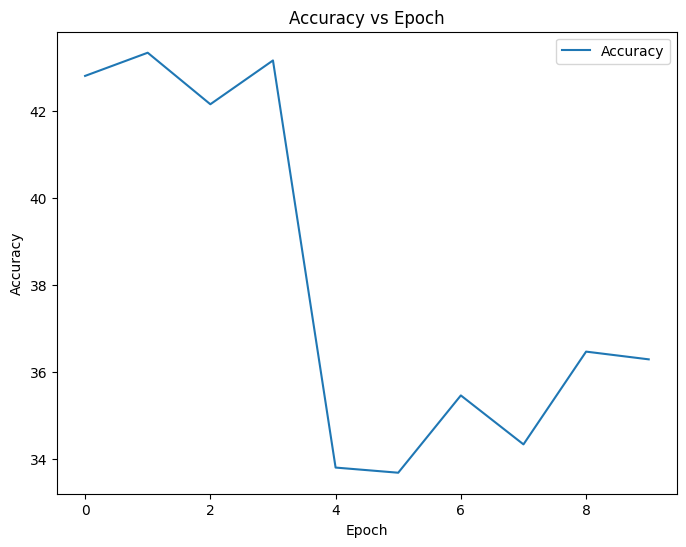

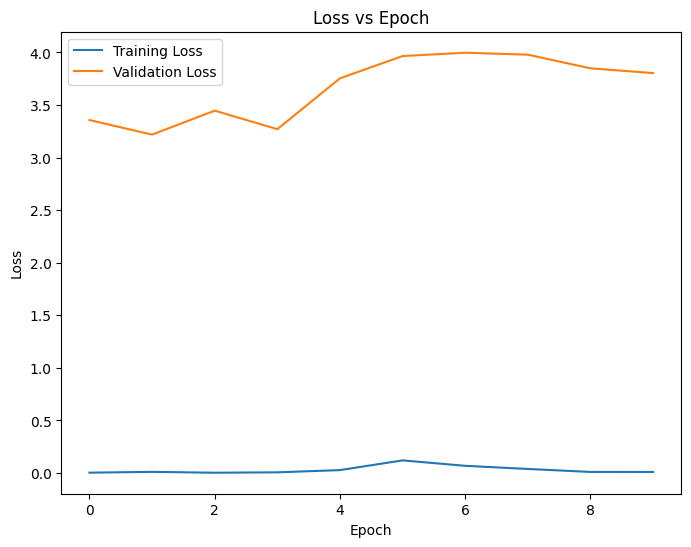

In [21]:
def validation_step(loader, model):
    total_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        model.eval()

        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward
            y_hat = model(x)
            loss = criterion(y_hat, y)
            total_loss += loss.item() * x.size(0)
            num_samples += x.size(0)

    model.train()
    return total_loss / num_samples

def check_accuracy(loader, model):
  num_corrects = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      # sending the data to the device
      x = x.to(device)
      y = y.to(device)

      # preparing the data for the model


      # forward
      y_hat = model(x)

      # calculate the accuracy
      _, labels = y.max(1)
      _, predictions = y_hat.max(1)
      num_corrects += (predictions == labels).sum()
      num_samples += predictions.size(0)

  print(f"Accuracy: {num_corrects}/{num_samples}: {num_corrects/num_samples*100:.2f}")
  model.train()
  return num_corrects, num_samples

epoch_list = []
accuracy_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0

    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        for index, (x,y) in enumerate(tepoch):
            # send the data to the device
            x = x.to(device)
            y = y.to(device)

            # prepare the data

            # forward
            y_hat = model(x)
            loss = criterion(y_hat, y)
            running_loss += loss

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item())

        epoch_list.append(epoch)
        train_loss = running_loss.item() / len(train_loader)
        train_loss_list.append(train_loss)

        val_loss = validation_step(test_loader, model)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch}: train_loss: {train_loss}, val_loss: {val_loss}")
        num_corrects, num_samples = check_accuracy(test_loader, model)

        # Calculate accuracy and append to lists
        accuracy = num_corrects / num_samples * 100
        accuracy_list.append(accuracy)

epoch_list = torch.tensor(epoch_list)
accuracy_list = torch.tensor(accuracy_list)
train_loss_list = torch.tensor(train_loss_list)
val_loss_list = torch.tensor(val_loss_list)

epoch_list = epoch_list.cpu().numpy()
accuracy_list = accuracy_list.cpu().numpy()
train_loss_list = train_loss_list.cpu().numpy()
val_loss_list = val_loss_list.cpu().numpy()

torch.save(model.state_dict(), "models/my_model.pth")

# Plot accuracy vs epoch
plt.figure(figsize=(8, 6))
plt.plot(epoch_list, accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.savefig('figures/accuracy_vs_epoch.png')
plt.show()

# Plot loss vs epoch
plt.figure(figsize=(8, 6))
plt.plot(epoch_list, train_loss_list, label='Training Loss')
plt.plot(epoch_list, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.savefig('figures/loss_vs_epoch.png')
plt.show()

Inferencia

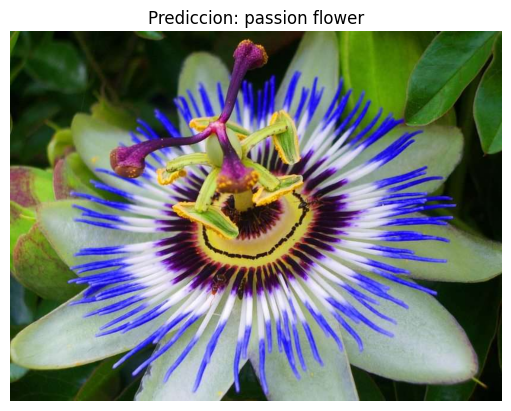

In [64]:
import torch
import torchvision.transforms as transforms
import skimage.io as skio
import matplotlib.pyplot as plt

# Definir la ruta de la imagen a inferir
image_path = './test_imgs/desconocida.jpg'

# Cargar la imagen y aplicar transformaciones
image = skio.imread(image_path)
flower_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_W, IMAGE_H)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
image_tensor = flower_transform(image).unsqueeze(0)

# Mover la imagen al dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)

# Cargar el modelo entrenado
model = MyCNN(num_channels=3, num_out_ch=NUM_OUT_CH, img_w=IMAGE_W, img_h=IMAGE_H, num_classes=102)
model.load_state_dict(torch.load("models/my_model.pth", map_location=device))
model = model.to(device)

# Realizar la inferencia
model.eval()
with torch.no_grad():
    output = model(image_tensor)

# Obtener la clase predicha
_, predicted_class = output.max(1)
predicted_class = predicted_class.item()

# Obtener el nombre de la clase
class_name = CLASSES[predicted_class]

# Mostrar la imagen y la clase predicha
plt.imshow(image)
plt.axis('off')
plt.title(f'Prediccion: {class_name}')
plt.show()